In [35]:
import numpy as np

def compute_eigenbasis(i, mat):
    """
    i-th eigenbasis
    """
    U, S, Vt = np.linalg.svd(mat, full_matrices=False)
    u_i = U[:, i].reshape(-1, 1)
    v_i = Vt[i, :].reshape(1, -1)
    eigenbasis = np.dot(u_i, v_i)
    return eigenbasis

In [36]:

# d = 20
# rows, cols = d//2, d

# # Generate a random matrix
# random_matrix = np.random.rand(rows, cols)
# row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
# random_matrix = random_matrix / row_norms


# # top eigenspace, for example
# _ = compute_eigenbasis(0, random_matrix)

# U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
# kappa = S[0]/S[-1]
# print(kappa)

In [37]:
# Generate a poorly conditioned random matrix, enforce "halfing" eigenvalue sequence

d = 1000
col = d

kappa = 1/d**2 # want this to be "poly d"
s = [1]
while s[-1] > 2 * kappa:
  s += [s[-1]/2]

row = len(s)

# generate a random basis, U of dimension row x row

U_rand = np.random.randn(row, row)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
U, _ = np.linalg.qr(U_rand)

V_rand = np.random.randn(col, row)
V, _ = np.linalg.qr(V_rand)

random_matrix = np.dot(np.dot(U, np.diag(s)), V.T)
row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
random_matrix = random_matrix / row_norms

U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
print(S[0]/S[-1]) # see the damage caused by normalizing

462510.48771281407


In [38]:
# Kaczmarz
import numpy as np

def kaczmarz(iter, mat, b=0, random=True, n=10, lbp=False):
    """ 
    Kaczmarz Algorithm (equal norm rows): 
      1. sample row from `mat` at random
      2. remove the projection of iterate x along this row

    [iter: number of iterations], [mat: matrix],
    [random: random initialization of x_0 on the sphere], [n: add iterates to tracking list every `n` iterations]
    """
    # Set numerical precision
    dtype = np.float16 if lbp else np.float64  # Use lower precision if lbp=True

    # Get dimensions
    row, col = mat.shape[0], mat.shape[1]

    # Convert matrix and b to specified precision
    mat = mat.astype(dtype)
    b = np.array(b, dtype=dtype)

    # Initialize x
    if random:
        x = np.random.rand(col).astype(dtype)
        x = (x / np.linalg.norm(x)).astype(dtype)  # Normalize with proper precision
    else:
        x = np.zeros(col, dtype=dtype)

    iterates = []
    
    # Iterative updates
    for i in range(iter):
        a_i = mat[np.random.randint(0, row), :].astype(dtype)  # Pick a row and ensure precision
        projection_factor = ((b - np.inner(a_i, x)) / (np.linalg.norm(a_i) ** 2)).astype(dtype)
        x = (x + projection_factor * a_i).astype(dtype)

        if i % n == 0:
            iterates.append(x)

    return iterates


In [50]:
import matplotlib.pyplot as plt

# if proj_iterates has r rows (for each eigenvalue) and t columns (for each iterate), visualize the first k using "top k"
# visiualize just the last row (bottom eigenspace) using min_k = 1000000 and top_k= 1000000 (some large numbers)
def plot_projections(proj_iterates, min_k=0, top_k=3, n=10, title="Title Missing"):
    nums = [i * n for i in range(len(proj_iterates[0]))]

    # Define a color map for distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, top_k))

    plt.figure(figsize=(8, 6))  # Set figure size

    if min_k > len(proj_iterates):
        min_k = len(proj_iterates) - 1
        
    for k in range(min_k, min(len(proj_iterates), top_k)):
        plt.plot(nums, [proj_iterates[k][i] for i in range(len(proj_iterates[0]))],
                 color=colors[k], label=f"Eigenvector {k+1}", linewidth=2)

    plt.xlabel("Iterations")
    plt.ylabel("Projection")
    plt.legend(title="Eigenspace")  # Add legend title
    plt.title(title)
    plt.show()

    return 0


In [59]:
steps = 150
iterates = kaczmarz(steps, random_matrix, n=1)
print(len(iterates))

# best rank k approx; top k eigenbases
rank_k = [compute_eigenbasis(k, random_matrix) for k in range(S.shape[0])]
# print(rank_k[0].shape)

# project the iterates onto each of the eigenspaces
normalized_iterates = [iterates[i]/np.linalg.norm(iterates[i]) for i in range(len(iterates))]
proj_iterates = [[np.linalg.norm(np.matmul(rank_k[k], normalized_iterates[i])) for i in range(len(normalized_iterates))] for k in range(len(rank_k))]
print(len(proj_iterates), len(proj_iterates[0]))

150
4 150


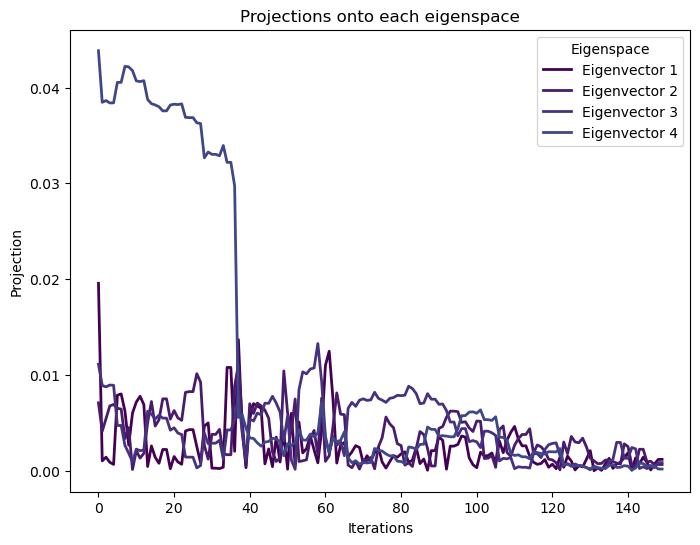

0

In [60]:
# to smooth iterates
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

smoothed = [
    moving_average(proj_iterates[k], 20) for k in range(len(rank_k))
]
# plot progress (put a very large number for top_k to see all eigenvalues)
# plot_projections(smoothed, top_k=6, n=1)
plot_projections(proj_iterates, min_k=0, top_k=15, n=1, title="Projections onto each eigenspace")

Think about a matrix $A \in \mathbb{R}^{4 \times 4}$ with eigenvalues $(1, 1, 1/\kappa, 1/\kappa)$. So, $$ A = v_1 v_1 ^\top + v_2 v_2 ^\top  + \frac{1}{\kappa} (v_3 v_3 ^\top + v_4 v_4^\top)$$
where $v_i$ are mutually orthogonal unit eigenvectors. Think about $A$ as a mixture of projections orthogonal to $T = \text{span}(v_1, v_2)$ and $B = \text{span}(v_3, v_4)$, its top and bottom subspaces.



In [61]:
kappa = 5
depth = 4

eig = np.array([[1/(kappa ** i), 1/(kappa ** i)] for i in range(depth//2)]).ravel()
S = np.diag(eig)

V_rand = np.random.randn(depth, depth)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
V, _ = np.linalg.qr(V_rand)

A = np.dot(V, np.dot(S, V.T))
row_norms = np.linalg.norm(A, axis=1, keepdims=True)  # Compute row-wise norms
A = A / row_norms


U, S, Vt = np.linalg.svd(A, full_matrices=False)
print(S)
print(U)
print(Vt.T)

[1.60253777 1.09591522 0.38510932 0.28728613]
[[-0.52351466 -0.45863217 -0.12189917  0.70762244]
 [ 0.59403205 -0.05170502 -0.75380003  0.27611236]
 [-0.15050641  0.87745083 -0.01202546  0.45528371]
 [ 0.59195113 -0.13062607  0.64558616  0.46448809]]
[[-0.62409961 -0.42062461 -0.09747342  0.6512093 ]
 [ 0.51848571 -0.03928743 -0.7768042   0.35525246]
 [-0.20711583  0.90065765 -0.00914774  0.38188368]
 [ 0.5466034  -0.10172133  0.6220856   0.55125946]]


In [43]:
# # Sadly, normalizing rows destroys the nice structure :(
# V_1, V_2 = V[:, :2], V[:, 2:]   # principal and minor eigenspace
# print(V_1.shape, V_2.shape)
# x = np.random.rand(4)
# x = x/np.linalg.norm(x)
# print("This norm is significant: ", np.linalg.norm(np.dot(A, x) - (np.dot(np.dot(V_1, V_1.T), x) + 1/kappa * np.dot(np.dot(V_2, V_2.T), x))))

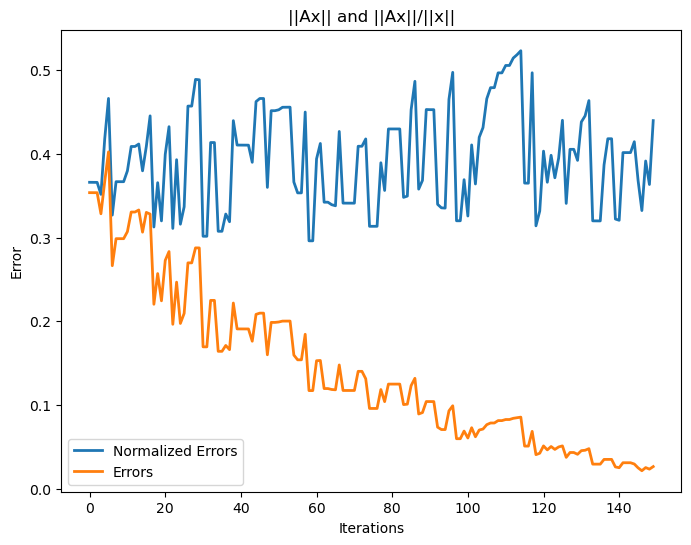

[0.966, 0.966, 0.966, 0.934, 0.8784, 0.863, 0.8154, 0.8145, 0.8145, 0.8145, 0.809, 0.8086, 0.8086, 0.8086, 0.8076, 0.807, 0.737, 0.705, 0.7036, 0.702, 0.683, 0.6553, 0.6323, 0.628, 0.625, 0.6226, 0.591, 0.591, 0.5884, 0.589, 0.5625, 0.5625, 0.5444, 0.5444, 0.534, 0.534, 0.522, 0.5215, 0.505, 0.4656, 0.4656, 0.4656, 0.4656, 0.4524, 0.451, 0.4504, 0.4504, 0.445, 0.4402, 0.4402, 0.4402, 0.44, 0.44, 0.44, 0.4365, 0.4363, 0.4363, 0.4104, 0.3965, 0.3965, 0.3887, 0.372, 0.35, 0.35, 0.35, 0.35, 0.347, 0.3447, 0.3447, 0.3447, 0.3447, 0.3433, 0.3433, 0.315, 0.3066, 0.3066, 0.3066, 0.3047, 0.2927, 0.2913, 0.2913, 0.2913, 0.2913, 0.2896, 0.2896, 0.2727, 0.2715, 0.2502, 0.2476, 0.2305, 0.2305, 0.2305, 0.2173, 0.2114, 0.2115, 0.2006, 0.1998, 0.1875, 0.1875, 0.1871, 0.1869, 0.1781, 0.1713, 0.1677, 0.1659, 0.1649, 0.1644, 0.1644, 0.1643, 0.1643, 0.1641, 0.1641, 0.1641, 0.1641, 0.1641, 0.1403, 0.1403, 0.1385, 0.1305, 0.1287, 0.1276, 0.1274, 0.1273, 0.1272, 0.1271, 0.1169, 0.11084, 0.1074, 0.1074, 0.105

In [63]:
steps = 150
b = 0 # np.random.randn(1)

iterates = kaczmarz(steps, A, b=b, n=1, lbp=True)

errors = [np.linalg.norm(np.dot(A, iterates[i])) for i in range(len(iterates))]

normalized_iterates = [iterat/np.linalg.norm(iterat) for iterat in iterates]
normalized_errors = [np.linalg.norm(np.matmul(A, normalized_iterates[i])) for i in range(len(normalized_iterates))]

norms = [np.linalg.norm(iterates[i]) for i in range(len(iterates))]
nums = [i for i in range(len(iterates))]

smoothed_normalized_errors = moving_average(normalized_errors, 20)
smoothened_errors = moving_average(errors, 20)

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, normalized_errors, label=f"Normalized Errors", linewidth=2)
plt.plot(nums, errors, label=f"Errors", linewidth=2)
plt.title("||Ax|| and ||Ax||/||x||")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print(norms)

In [64]:
# full rank case
print(kappa)
print(normalized_errors[-10])
print("balanced between T, B: ", 1/kappa * 1 + (1 - 1/kappa) * 1/kappa)



5
0.3206514630141565
balanced between T, B:  0.36


[0.59   0.4414 0.2493 0.5723]


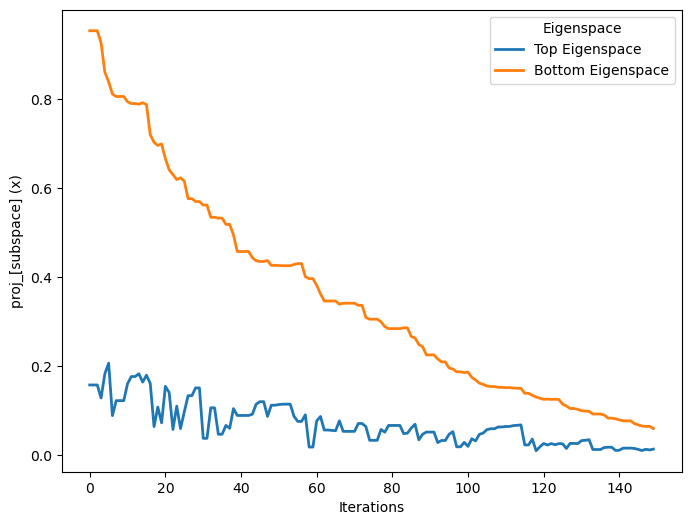

In [65]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)

print(iterates[0])

# Projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in iterates]

# Projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")

plt.xlabel("Iterations")
plt.ylabel("proj_[subspace] (x)")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

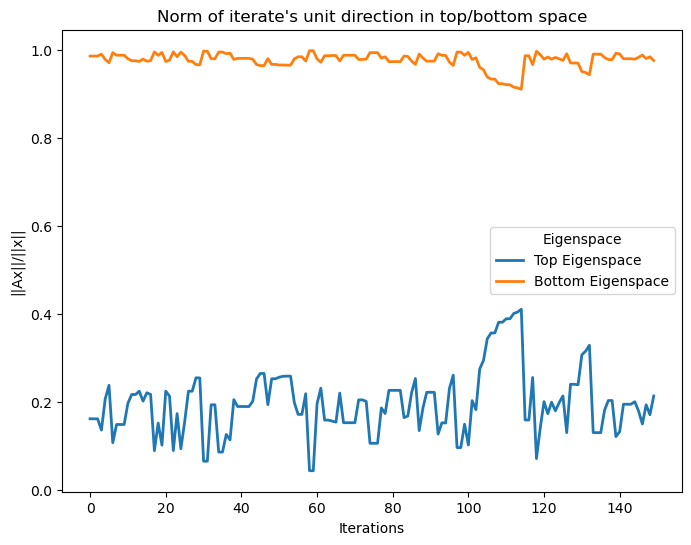

In [66]:
# Normalized projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in normalized_iterates]

# Normalized projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")
plt.title("Norm of iterate's unit direction in top/bottom space")
plt.xlabel("Iterations")
plt.ylabel("||Ax||/||x||")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

In [69]:
# Do iterates in the smaller subspace "spin"?
norm_proj_2 = [(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) / np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]     # pretty much just x again, but just to be careful!
# norm_proj_2 = [(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) / np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in normalized_iterates]     # pretty much just x again, but just to be careful!

# print(norm_proj_2)
consecutive_angles = [0 for i in range(len(norm_proj_2 ) - 1)]
for i in range(1, len(norm_proj_2)):
    consecutive_angles[i-1] = np.dot(norm_proj_2[i].T, norm_proj_2[i-1])

print(consecutive_angles)

[0.99999999999716, 1.0, 0.9977324500054672, 0.9999627946942258, 0.9999986331971877, 0.995239549928618, 0.9999101208210348, 0.9999999999999999, 0.9999999999999999, 0.999999979830881, 0.9999480494109769, 0.9999999999999998, 0.9999999901853449, 0.9999143789580038, 0.9999387086218101, 0.9998742974795235, 0.9961742344525742, 0.9998449006941599, 0.9998330342372171, 0.9999278946727812, 0.9999982794357596, 0.996776334595879, 0.9996327914217589, 0.9995727556350354, 0.9999995178106775, 0.9998123028947323, 1.0, 0.9999995136901998, 0.9999999838267258, 0.9957915768069725, 0.9999999949261669, 0.9997847892053499, 1.0000000000000002, 0.9982555744936368, 0.9999999947121361, 0.9999692652854706, 0.9998421654576444, 0.9996739173467613, 0.9962803944849403, 0.9999999986588854, 0.9999999986589491, 0.9999999986590127, 0.9999697393344313, 0.9998186871552402, 0.9999992850871038, 0.9999999999999998, 0.9988134253311702, 0.9994205890678061, 1.0, 0.9999999970419338, 0.9999996833296556, 0.9999999987026096, 0.9999999

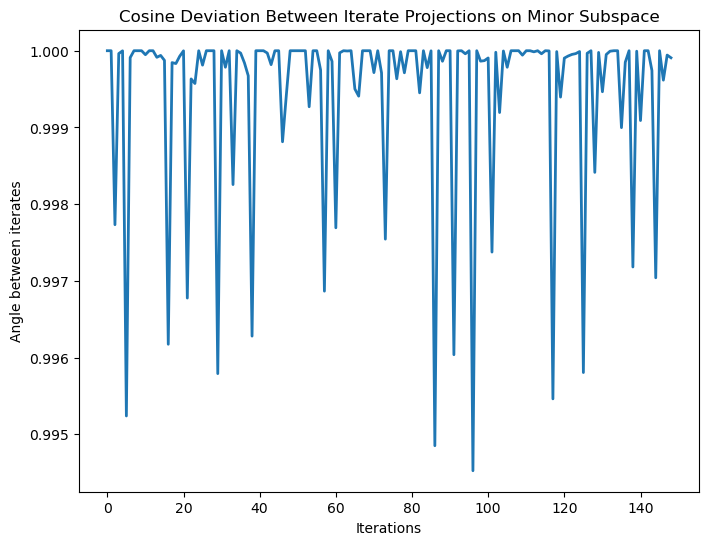

In [70]:
import matplotlib.pyplot as plt

nums = [i for i in range(len(consecutive_angles))]
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, consecutive_angles, linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Angle between iterates")
# plt.ylim(0, 1)  # Enforce y-axis range
plt.title("Cosine Deviation Between Iterate Projections on Minor Subspace")
plt.show()